
# üìà Stock Price Analysis - Model Validation
**Ticker:** {TICKER}  
**Analysis Date:** {current_date}

## Table of Contents
1. [Data Loading](#data-loading)  
2. [Markov Chain Analysis](#markov-analysis)  
3. [Simulations](#monte-carlo)  
4. [Backtesting](#backtesting)  
5. [Performance Metrics](#metrics)  
6. [Benchmark Comparison](#benchmark)  
7. [Risk Analysis](#risk)  
8. [Residual Diagnostics](#residuals)


In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
import os
from IPython.display import display, Markdown
from statsmodels.tsa.stattools import acf

sys.path.append("C:/Users/Emmanuel/Documents/Personal/Markov Chain/stock-markov-analysis")

# Custom modules
from src.data_preprocessor import load_processed_data
from src.markov_model import get_transition_matrix
from src.simulation import simulate_price_path, calculate_performance_metrics, save_performance_metrics
from src.visualization import plot_transition_matrices

In [2]:
class ColorLogger:
    """Custom logging class with colored output"""
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    
    @classmethod
    def info(cls, message):
        print(f"{cls.OKBLUE} {message}{cls.ENDC}")
    
    @classmethod
    def success(cls, message):
        print(f"{cls.OKGREEN}‚úÖ {message}{cls.ENDC}")
    
    @classmethod
    def warn(cls, message):
        print(f"{cls.WARNING}‚ö†Ô∏è {message}{cls.ENDC}")
    
    @classmethod
    def error(cls, message):
        print(f"{cls.FAIL}‚ùå {message}{cls.ENDC}")

# Configuration
class Config:
    TICKER = "AAPL"
    N_STATES = 5
    N_SIMULATIONS = 1000
    FORECAST_DAYS = 100
    BACKTEST_WINDOW = 252
    PLOT_STYLE = "dark_background"
    FIGURE_DIR = "reports/figures"
    COLOR_PALETTE = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

In [3]:
# Initialize environment
plt.style.use(Config.PLOT_STYLE)
os.makedirs(Config.FIGURE_DIR, exist_ok=True)
current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# #  {"id": "data-loading"}
# # ## 1. Data Loading

In [4]:
ColorLogger.info("‚ÑπÔ∏è Initializing analysis...")
try:
    ColorLogger.info(f"Loading processed data for {Config.TICKER} üìÇ")
    data = load_processed_data(Config.TICKER)
    ColorLogger.success(f"Loaded {len(data)} records ({(data.index[-1] - data.index[0]).days} days)")
    
    display(Markdown("### Sample Data"))
    print(tabulate(data.head(), headers="keys", tablefmt="fancy_grid"))
    
except Exception as e:
    ColorLogger.error(f"Data loading failed: {str(e)}")
    raise



 ‚ÑπÔ∏è Initializing analysis...
 Loading processed data for AAPL üìÇ
‚úÖ Loaded 752 records (1088 days)


### Sample Data

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Date                      ‚îÇ    Open ‚îÇ    High ‚îÇ     Low ‚îÇ   Close ‚îÇ    Volume ‚îÇ   Dividends ‚îÇ   Stock Splits ‚îÇ   Daily_Return ‚îÇ   State ‚îÇ State_Description   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê

{"id": "markov-analysis"}
## 2. Markov Chain Analysis

 üîÆ Analyzing Markov Chain transitions for AAPL at 2025-02-28 00:35:56 .... üèÅ


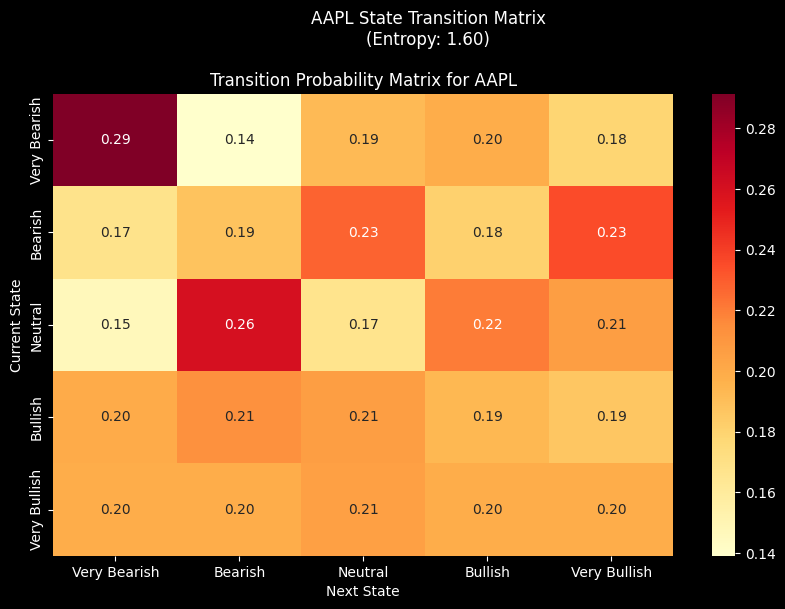

In [5]:
ColorLogger.info(f"üîÆ Analyzing Markov Chain transitions for {Config.TICKER} at {current_date} .... üèÅ")
try:
    transition_matrix, entropy = get_transition_matrix(data['State'].values, Config.N_STATES)
    state_labels = ['Very Bearish', 'Bearish', 'Neutral', 'Bullish', 'Very Bullish']
    
    # Get figure from plotting function
    fig = plot_transition_matrices(
        {Config.TICKER: transition_matrix}, 
        state_labels,
        save_path=Config.FIGURE_DIR
    )
    
    fig.suptitle(f"{Config.TICKER} State Transition Matrix\n(Entropy: {np.mean(entropy):.2f})", y=1.02)
    
    plt.show()
    
except Exception as e:
    ColorLogger.error(f"Markov analysis failed: {str(e)}")
    raise

%% {"id": "monte-carlo"}
## 3. Simulations


 üé≤ Running Simulations...


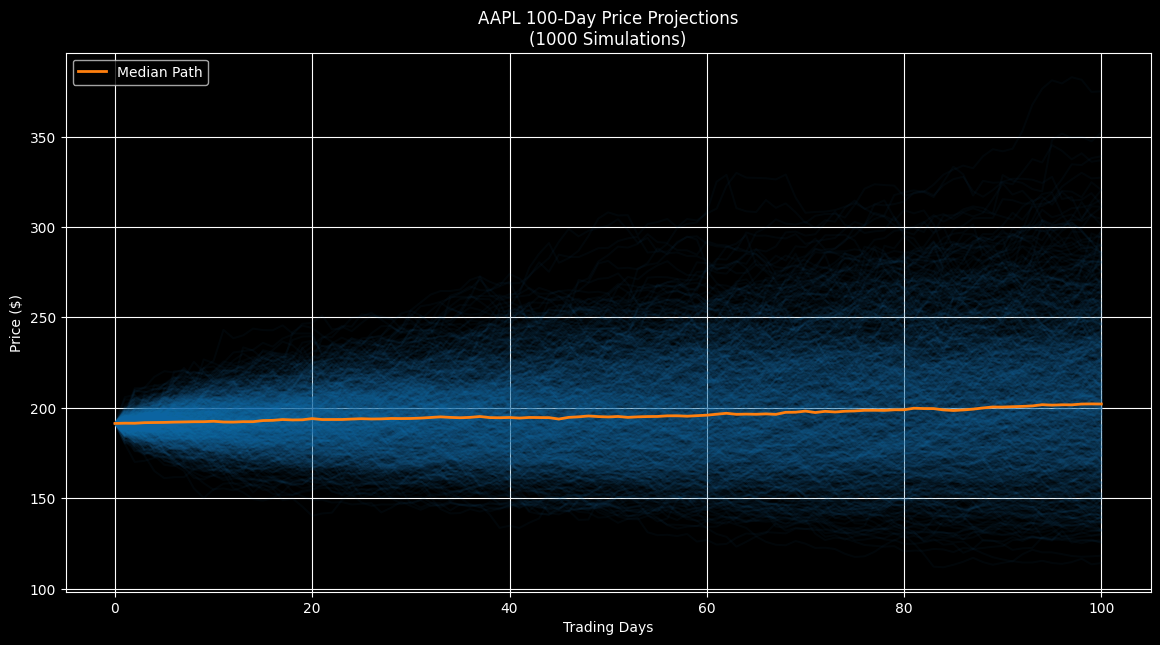

In [6]:
ColorLogger.info("üé≤ Running Simulations...")
try:
    initial_price = data['Close'].iloc[-1]
    returns_by_state = [data[data['State'] == s]['Daily_Return'].values 
                       for s in range(Config.N_STATES)]
    
    # Vectorized simulation
    simulations = np.array([
        simulate_price_path(initial_price, transition_matrix, returns_by_state, Config.FORECAST_DAYS)
        for _ in range(Config.N_SIMULATIONS)
    ])
    
    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(simulations.T, color=Config.COLOR_PALETTE[0], alpha=0.05)
    plt.plot(np.median(simulations, axis=0), color=Config.COLOR_PALETTE[1], lw=2, label='Median Path')
    plt.title(f"{Config.TICKER} {Config.FORECAST_DAYS}-Day Price Projections\n({Config.N_SIMULATIONS} Simulations)")
    plt.xlabel("Trading Days")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{Config.FIGURE_DIR}/{Config.TICKER}_simulations.png", dpi=300)
    plt.show()
    
except Exception as e:
    ColorLogger.error(f"Simulations failed: {str(e)}")
    raise

{"id": "backtesting"}
## 4. Backtesting


In [7]:
def rolling_backtest(df):
    """Enhanced rolling window backtester with progress tracking"""
    predictions = []
    actuals = []
    
    for i in range(Config.BACKTEST_WINDOW, len(df)):
        # Show progress
        if i % 50 == 0:
            progress = (i - Config.BACKTEST_WINDOW) / (len(df) - Config.BACKTEST_WINDOW)
            ColorLogger.info(f"Backtest progress: {progress:.1%}")
        
        # Train/test split
        train = df.iloc[i-Config.BACKTEST_WINDOW:i]
        test = df.iloc[i]
        
        # Model update
        tm, _ = get_transition_matrix(train['State'].values, Config.N_STATES)
        returns = [train[train['State'] == s]['Daily_Return'].values 
                  for s in range(Config.N_STATES)]
        
        # Prediction
        pred = simulate_price_path(train['Close'].iloc[-1], tm, returns, 1)[-1]
        
        predictions.append(pred)
        actuals.append(test['Close'])
    
    return np.array(predictions), np.array(actuals), df.index[Config.BACKTEST_WINDOW:]


 üîç Running rolling window backtest...
 Backtest progress: 9.6%
 Backtest progress: 19.6%
 Backtest progress: 29.6%
 Backtest progress: 39.6%
 Backtest progress: 49.6%
 Backtest progress: 59.6%
 Backtest progress: 69.6%
 Backtest progress: 79.6%
 Backtest progress: 89.6%
 Backtest progress: 99.6%


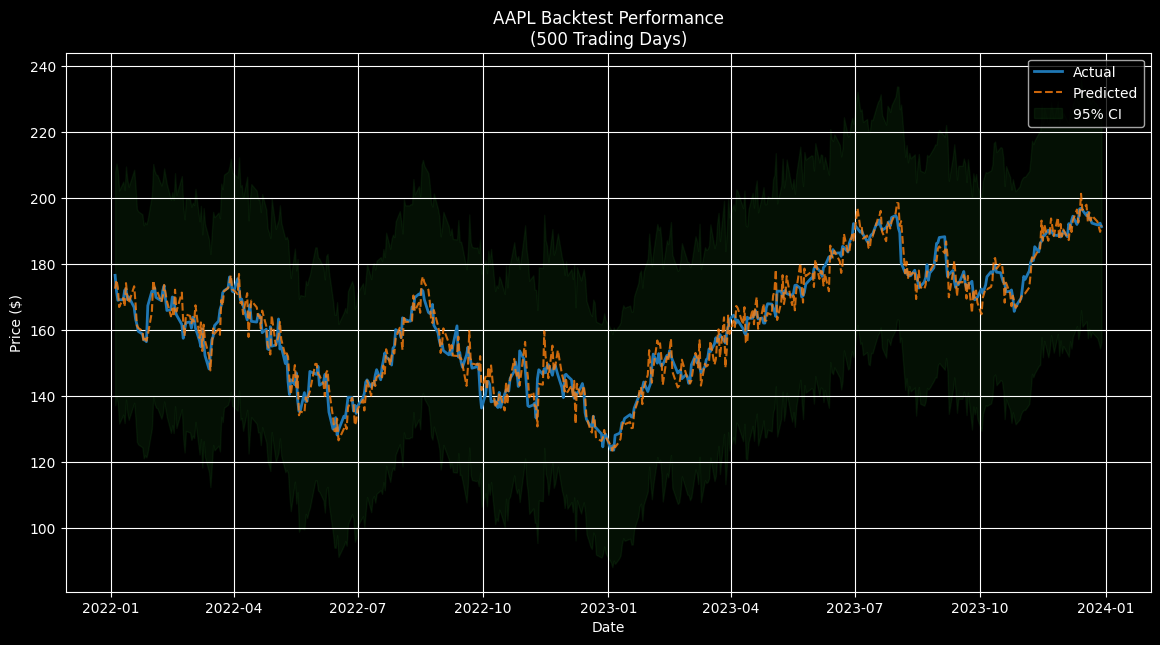

In [8]:
ColorLogger.info("üîç Running rolling window backtest...")
try:
    predictions, actuals, test_dates = rolling_backtest(data)
    
    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, actuals, label='Actual', color=Config.COLOR_PALETTE[0], lw=2)
    plt.plot(test_dates, predictions, label='Predicted', 
             color=Config.COLOR_PALETTE[1], ls='--', alpha=0.8)
    
    # Confidence bands
    plt.fill_between(test_dates,
                    predictions - 1.96*np.std(predictions),
                    predictions + 1.96*np.std(predictions),
                    color=Config.COLOR_PALETTE[2], alpha=0.1, label='95% CI')
    
    plt.title(f"{Config.TICKER} Backtest Performance\n({len(actuals)} Trading Days)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{Config.FIGURE_DIR}/{Config.TICKER}_backtest.png", dpi=300)
    plt.show()
    
except Exception as e:
    ColorLogger.error(f"Backtesting failed: {str(e)}")
    raise

# {"id": "metrics"}
# # ## 5. Performance Metrics

In [9]:
ColorLogger.info("üìà Calculating performance metrics...")
try:
    metrics, summary = calculate_performance_metrics(
        actual_prices=actuals,
        predicted_prices=predictions,
        simulations=simulations,
        df=data,
        current_price=initial_price,
        forecast_days=Config.FORECAST_DAYS
    )
    
    save_performance_metrics(metrics, f"reports/{Config.TICKER}_performance.md")
     
except Exception as e:
    ColorLogger.error(f"Metrics calculation failed: {str(e)}")
    raise

 üìà Calculating performance metrics...

üìä Performance Summary (100 days)
+-----------------------+-------------------+
| Metric                |             Value |
|-----------------------+-------------------|
| Current Price         |           $191.38 |
| Forecast Horizon      |          100 days |
| Predicted Mean Price  |           $204.64 |
| Price Range           | $114.16 - $375.08 |
| Historical Volatility |             1.75% |
| Simulated Volatility  |            13.08% |
| 90% CI                | $147.76 - $269.86 |
| 95% CI                | $139.19 - $285.46 |
+-----------------------+-------------------+


{"id": "benchmark"}
# # ## 6. Benchmark Comparison

In [10]:
ColorLogger.info("Comparing with Random Walk benchmark...")
try:
    rw_predictions = data['Close'].shift(1).loc[test_dates].values
    rw_metrics, _ = calculate_performance_metrics(actuals, rw_predictions)
    
    display(Markdown("### Random Walk Benchmark"))
    print(tabulate([[k, v] for k,v in rw_metrics.items()], 
                  headers=['Metric', 'Value'], 
                  tablefmt='psql'))
    
except Exception as e:
    ColorLogger.warn(f"Benchmark comparison failed: {str(e)}")


 Comparing with Random Walk benchmark...


### Random Walk Benchmark

+--------------+----------+
| Metric       |    Value |
|--------------+----------|
| RMSE         | 2.81574  |
| Hit Rate     | 0.503006 |
| Sharpe Ratio | 9.09594  |
+--------------+----------+


# # %% [markdown] {"id": "risk"}
# # ## 7. Risk Analysis

In [11]:
ColorLogger.info("Calculating risk metrics...")
try:
    final_prices = simulations[:, -1]
    returns = (final_prices - initial_price) / initial_price
    
    risk_metrics = [
        ["Expected Return", f"{np.mean(returns)*100:.2f}%"],
        ["Volatility (œÉ)", f"{np.std(returns)*100:.2f}%"],
        ["95% VaR", f"{np.percentile(returns, 5)*100:.2f}%"],
        ["Best Case (95%)", f"{np.percentile(returns, 95)*100:.2f}%"]
    ]
    
    display(Markdown("### Risk Metrics"))
    print(tabulate(risk_metrics, headers=['Metric', 'Value'], tablefmt='psql'))
    
except Exception as e:
    ColorLogger.warn(f"Risk analysis failed: {str(e)}")


 Calculating risk metrics...


### Risk Metrics

+-----------------+---------+
| Metric          | Value   |
|-----------------+---------|
| Expected Return | 6.93%   |
| Volatility (œÉ)  | 19.32%  |
| 95% VaR         | -22.79% |
| Best Case (95%) | 41.01%  |
+-----------------+---------+


 # %% [markdown] {"id": "residuals"}
# # ## 8. Residual Diagnostics

 Analyzing model residuals...


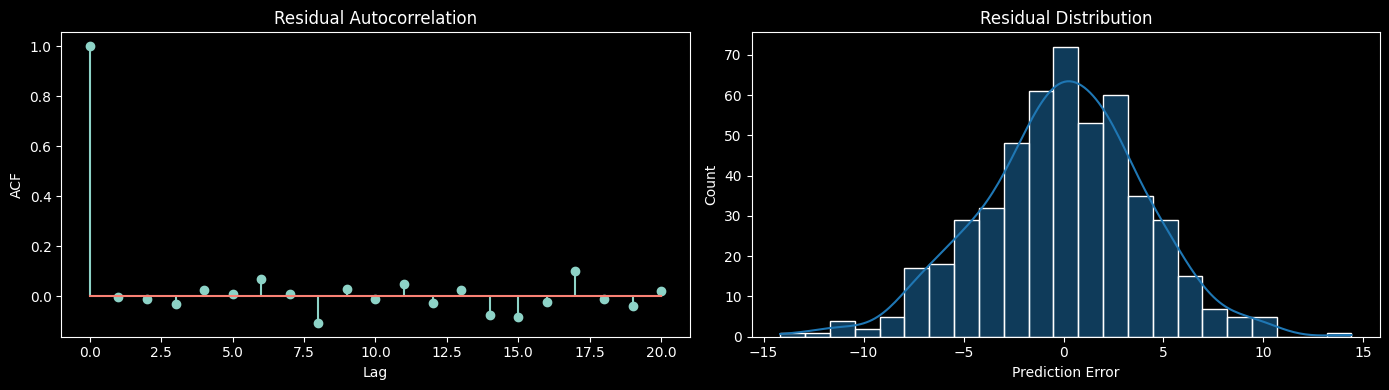

‚úÖ Analysis completed successfully at 00:36:26


In [12]:
ColorLogger.info("Analyzing model residuals...")
try:
    residuals = actuals - predictions
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    
    # Autocorrelation plot
    acf_vals = acf(residuals, nlags=20)
    ax[0].stem(acf_vals)
    ax[0].set_title("Residual Autocorrelation")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("ACF")
    
    # Distribution plot
    sns.histplot(residuals, kde=True, ax=ax[1], color=Config.COLOR_PALETTE[0])
    ax[1].set_title("Residual Distribution")
    ax[1].set_xlabel("Prediction Error")
    
    plt.tight_layout()
    plt.savefig(f"{Config.FIGURE_DIR}/{Config.TICKER}_residuals.png", dpi=300)
    plt.show()
    
except Exception as e:
    ColorLogger.warn(f"Residual analysis failed: {str(e)}")


ColorLogger.success(f"Analysis completed successfully at {datetime.now().strftime('%H:%M:%S')}")